# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and setup

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import time                        # timing how long it takes to import libraries

t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [32]:
# threshold = 55 # for 36a
# threshold = 35 # for 36b
threshold = 45 # for 36e

print(str(nm_per_pixel), "nm per pixel")

0.8849557522123894 nm per pixel


## 2. Load input data and apply grayscale

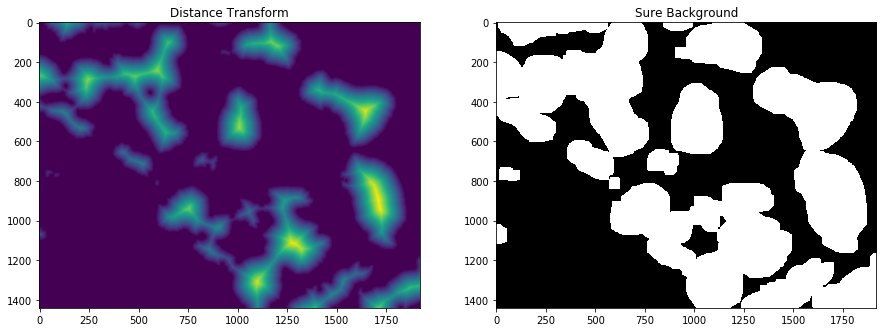

In [31]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME = "TES-36e-cropped.tif"

color_image, dist_transform, sure_bg = setup(IMAGE_NAME, threshold, False)

## 5. Contours derived from sure background & foreground

### Contour Agglomerates

Text(0.5, 1.0, 'sure foreground')

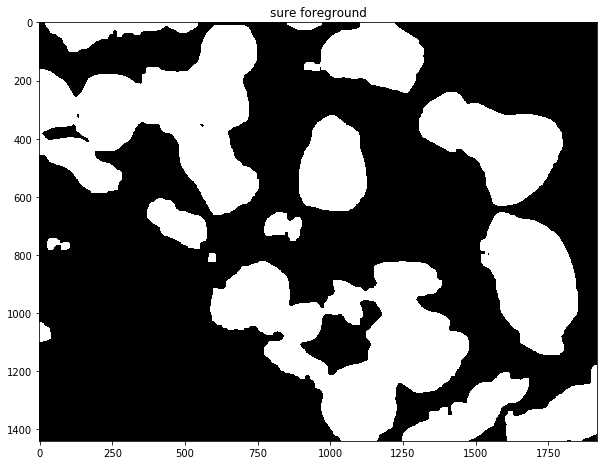

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
axs.imshow(sure_fg, cmap = plt.cm.gray)
axs.set_title("sure foreground")

Text(0.5, 1.0, 'unknown = background - foreground')

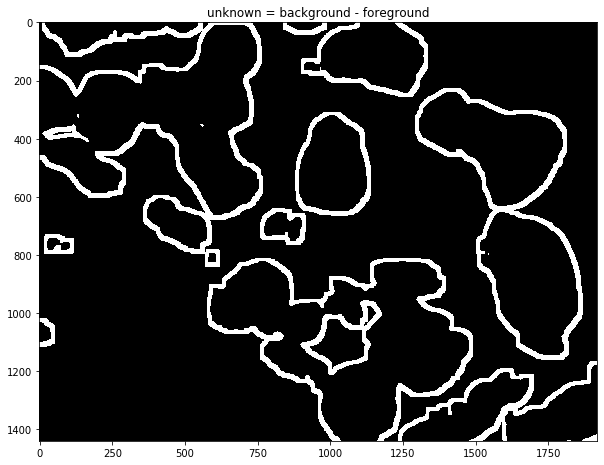

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = plt.cm.gray)
axs.set_title("unknown = background - foreground")

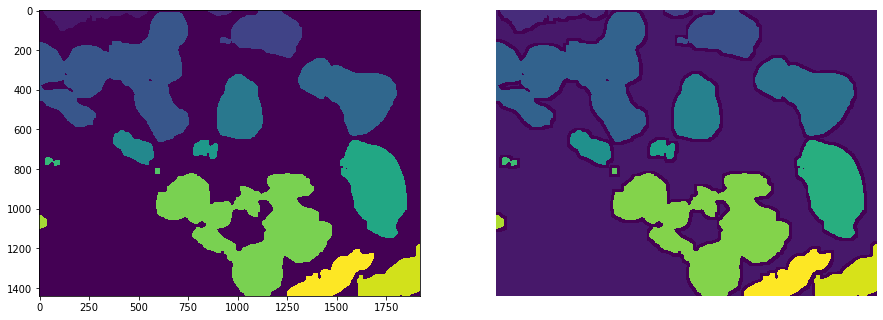

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
ax0.imshow(markers)

# If unknown's pixel is 255 (white), set corresponding pixel in markers to 0
markers[unknown==255] = 0
ax1.imshow(markers)

In [11]:
# copy input image
color_copy_1 = color_image.copy()

# TODO matrix multiplication optimization

for row in range(len(color_copy_1)):
    for col in range(len(color_copy_1[0])):
        if unknown[row][col] == 255:
            color_copy_1[row][col] = [255,0,0]

we set all boundary pixels to -1, then loop through all of them to make them red

then overlay red pixels on original image

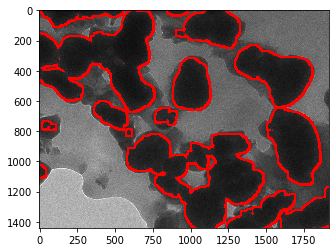

In [12]:
plt.imshow(color_copy_1)

### Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

Text(0.5, 1.0, 'sure foreground')

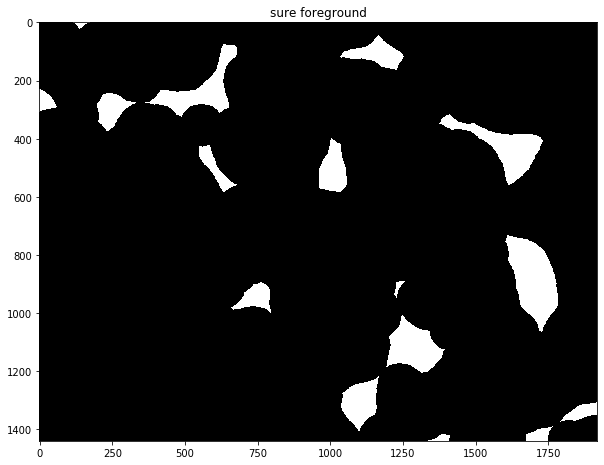

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.499999999*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [14]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

## 6. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

Text(0.5, 1.0, 'watershed markers')

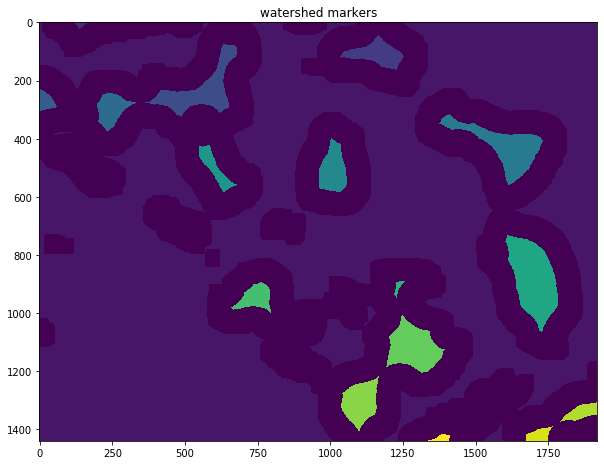

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, watershed_markers = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
watershed_markers += 1
# Now, mark the region of unknown with zero
watershed_markers[unknown_2==255] = 0

axs.imshow(watershed_markers)
axs.set_title("watershed markers")

Run watershed algorithm from particle centers

Text(0.5, 1.0, 'watershed markers')

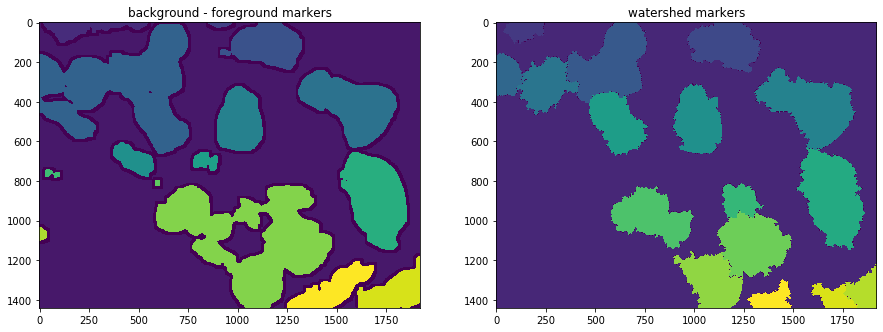

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# copy input image
watershed_color_copy = color_image.copy()

# perform watershed
cv.watershed(watershed_color_copy, watershed_markers)
watershed_color_copy[watershed_markers == -1] = [255,0,0]

ax0.imshow(markers)
ax0.set_title("background - foreground markers")
ax1.imshow(watershed_markers)
ax1.set_title("watershed markers")

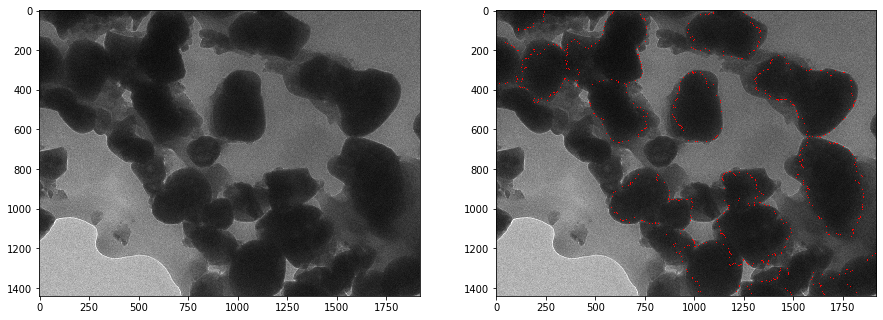

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

ax0.imshow(color_image)
ax1.imshow(watershed_color_copy)

First obtain contour pixels and get their colors

In [18]:
contour_colors, chords_color_copy = get_contour_colors(watershed_markers, color_image)

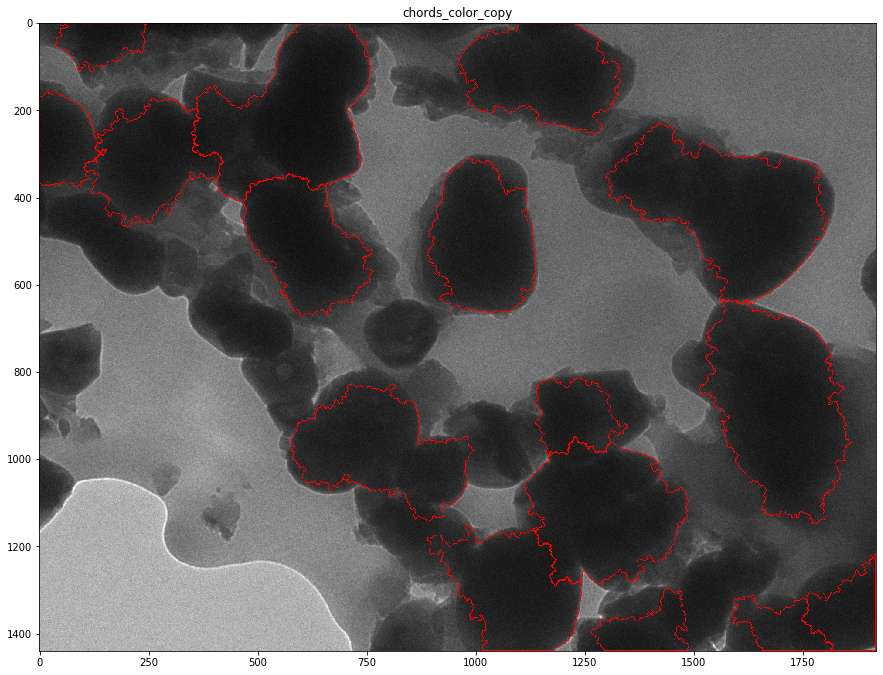

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.set_title("chords_color_copy")
axs.imshow(chords_color_copy)

In [21]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 23.974973234 seconds


## Find area of particles
 to see if it is worth it to run watershed on the current threshold

In [22]:
t_area_init = time.perf_counter()

dist_transform_thresh = get_watershed_threshold(dist_transform, sure_bg, color_image, expected_radius)
print(dist_transform_thresh)

0.49999999999999994


In [23]:
t_area_final = time.perf_counter()

In [24]:
print("time to find areas:", str(t_area_final - t_area_init), "seconds")

time to find areas: 42.43712046900001 seconds


In [26]:
particles = find_centerpoints(contour_colors)
# print(particles)

{2: [('x', 115.57719879369161), ('y', 43.55366589212439)], 4: [('x', 474.1197588897193), ('y', 191.32261421656622)], 3: [('x', 1002.6346081239122), ('y', 111.01314081018114)], 5: [('x', 59.70779946183811), ('y', 240.06974733590437)], 6: [('x', 213.28322448506398), ('y', 277.467248908297)], 7: [('x', 1357.0438584669753), ('y', 362.59766707096117)], 8: [('x', 883.1022302388066), ('y', 433.3648046897018)], 9: [('x', 530.2187199984792), ('y', 448.37979905516005)], 10: [('x', 1481.9500998365215), ('y', 778.7019442483909)], 11: [('x', 1084.5440494590418), ('y', 800.4705174323974)], 12: [('x', 684.185643720754), ('y', 866.2352770643703)], 13: [('x', 1129.6986632759758), ('y', 995.281936191375)], 14: [('x', 931.0509534018778), ('y', 1127.2377670978424)], 15: [('x', 1631.5329907381504), ('y', 1176.0406696803263)], 17: [('x', 1231.8214334514882), ('y', 1219.2929999276603)], 16: [('x', 1493.9516224188792), ('y', 1215.1465093411998)]}


In [27]:
long_pairs, particles = get_long_chord_lengths(particles, contour_colors)
# print(long_pairs)

[[2, (246, 3), (37, 50)], [4, (713, 1), (411, 383)], [3, (961, 90), (1334, 133)], [5, (20, 154), (95, 373)], [6, (361, 196), (159, 442)], [7, (1323, 324), (1811, 450)], [8, (982, 311), (1077, 663)], [9, (486, 368), (718, 638)], [10, (1563, 634), (1802, 1139)], [11, (1142, 829), (1350, 926)], [12, (579, 953), (998, 979)], [13, (1113, 1064), (1487, 1131)], [14, (891, 1179), (1227, 1389)], [15, (1918, 1217), (1821, 1438)], [17, (1473, 1304), (1267, 1400)], [16, (1592, 1324), (1819, 1437)]]


In [28]:
short_pairs, particles = get_short_chord_lengths(particles, contour_colors, long_pairs)
# print(short_pairs)

[((736, 329), (521, 145)), ((1160, 1), (1129, 192)), ((1, 282), (119, 232)), ((327, 374), (174, 224)), ((1527, 543), (1584, 294)), ((894, 524), (1119, 451)), ((544, 553), (667, 420)), ((1815, 823), (1575, 912)), ((1196, 984), (1267, 822)), ((796, 841), (781, 1068)), ((1268, 1275), (1317, 962)), ((1014, 1356), (1140, 1156)), ((1823, 1307), (1918, 1339)), ((1377, 1367), (1448, 1438)), ((1726, 1338), (1656, 1430))]


In [29]:
print(particles)

{2: [('x', 115.57719879369161), ('y', 43.55366589212439), ('a', 94.78739539097947), ('theta', -12.673860005623133)], 4: [('x', 474.1197588897193), ('y', 191.32261421656622), ('a', 215.46809899325092), ('theta', -51.670952674253876), ('b', 125.21498467761052)], 3: [('x', 1002.6346081239122), ('y', 111.01314081018114), ('a', 166.137332596162), ('theta', -173.4238857894455), ('b', 85.6191831876503)], 5: [('x', 59.70779946183811), ('y', 240.06974733590437), ('a', 102.42765517094033), ('theta', -108.90457584261165), ('b', 56.70626316318866)], 6: [('x', 213.28322448506398), ('y', 277.467248908297), ('a', 140.84425969793108), ('theta', -50.60927444644581), ('b', 94.80701594160583)], 7: [('x', 1357.0438584669753), ('y', 362.59766707096117), ('a', 223.0106054151975), ('theta', -165.52260429120585), ('b', 113.02690065880356)], 8: [('x', 883.1022302388066), ('y', 433.3648046897018), ('a', 161.32490932447112), ('theta', -105.10350645777817), ('b', 104.66636222002914)], 9: [('x', 530.2187199984792)

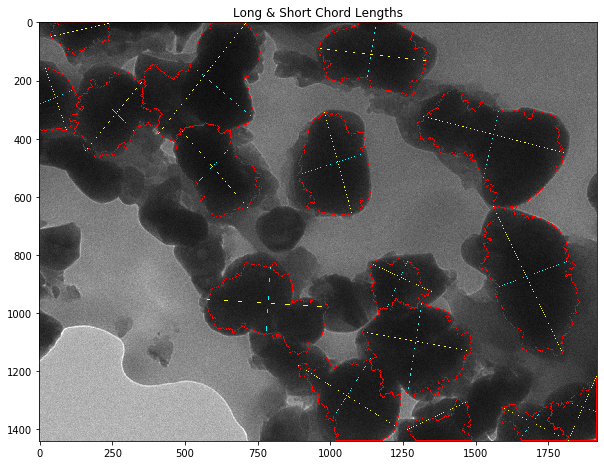

In [30]:
draw_long_lengths(chords_color_copy, long_pairs)
draw_short_lengths(chords_color_copy, short_pairs)
display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])